In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'])


In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_i = sales_i.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_i.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,50833,600282,1024825
1,2019-02-01,65670,775491,1323949
2,2019-03-01,89667,1058869,1807743
3,2019-04-01,60960,719871,1228992
4,2019-05-01,43410,512625,875173


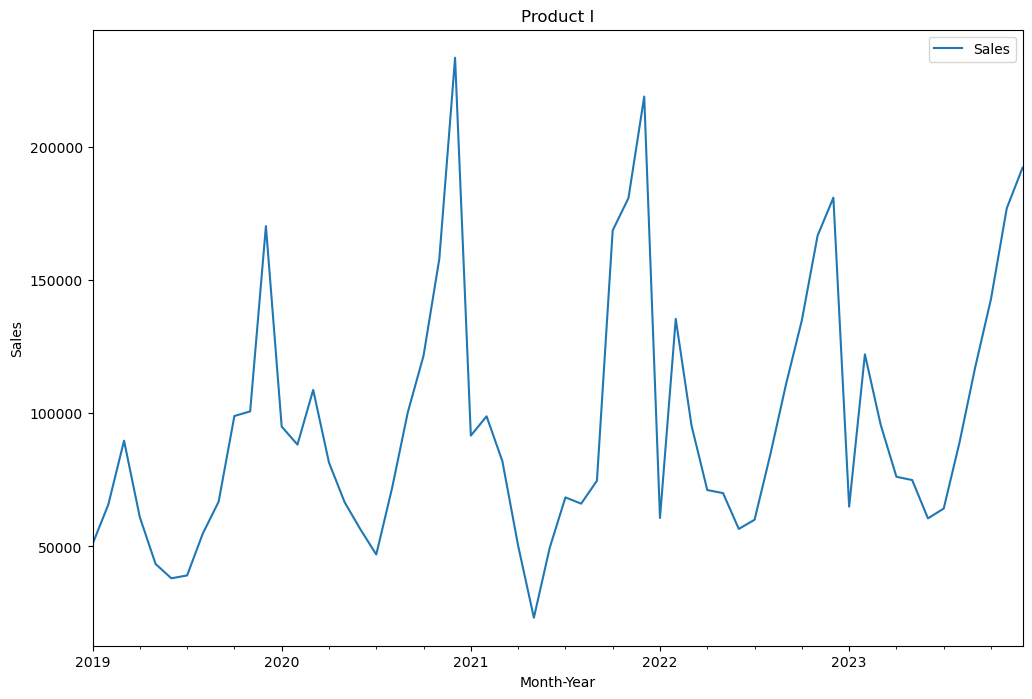

In [5]:
ax = sales_i.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product I')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_i[:48]
test=sales_i[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:33 - cmdstanpy - INFO - Chain [1] start processing
16:12:33 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1] done processing
16:12:44 - cmdstanpy - INFO - Chain [1] start processing
16:12:44 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   16253.410867  
1   18218.496525  
2   21131.768969  
3   18649.035847  
4   22543.460368  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
48,0.300,0.01,additive,15531.449470
24,0.100,0.01,additive,15539.613868
36,0.200,0.01,additive,15551.516418
12,0.010,0.01,additive,15616.480613
0,0.001,0.01,additive,16253.410867
...,...,...,...,...
65,0.500,1.00,multiplicative,39808.974356
70,0.500,10.00,additive,40306.717577
69,0.500,5.00,multiplicative,44643.016536
63,0.500,0.10,multiplicative,49921.875078


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [9]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.3, seasonality_prior_scale=0.01,seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [10]:
model.fit(train)

16:37:29 - cmdstanpy - INFO - Chain [1] start processing
16:37:30 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [12]:
future_dates['Market Size'] = sales_i['Market Size']
future_dates['Marketing Expense'] = sales_i['Marketing Expense']

In [13]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,600282,1024825
1,2019-02-01,775491,1323949
2,2019-03-01,1058869,1807743
3,2019-04-01,719871,1228992
4,2019-05-01,512625,875173
5,2019-06-01,449010,766568
6,2019-07-01,461693,788220
7,2019-08-01,647955,1106214
8,2019-09-01,788516,1346186
9,2019-10-01,1188838,2029631


In [14]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [15]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [16]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,60603.542810,29362.733506,92074.159332
49,2023-02-01,100020.366355,66662.454641,130154.642743
50,2023-03-01,84771.282768,51836.087016,118141.376690
51,2023-04-01,71336.151820,37305.022438,102731.702512
52,2023-05-01,70669.745068,34364.075057,101333.526819
53,2023-06-01,62050.570230,30994.086380,96644.105118
54,2023-07-01,64945.112490,29147.463970,94270.221622
55,2023-08-01,82261.584517,47896.431349,115411.198316
56,2023-09-01,101732.009019,66449.718866,134622.603318
57,2023-10-01,134338.388623,99902.176893,167121.011922


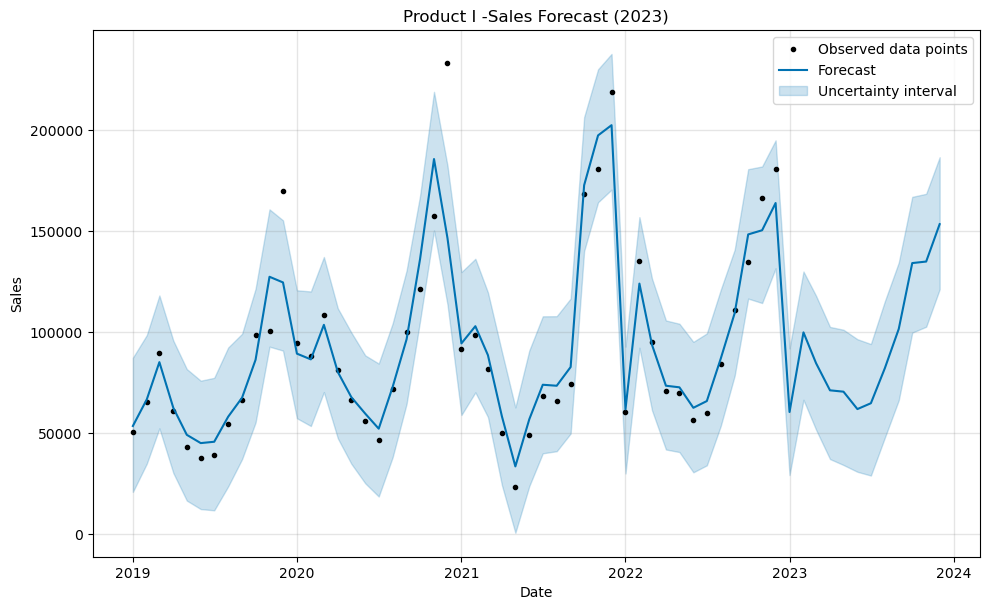

In [17]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product I -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

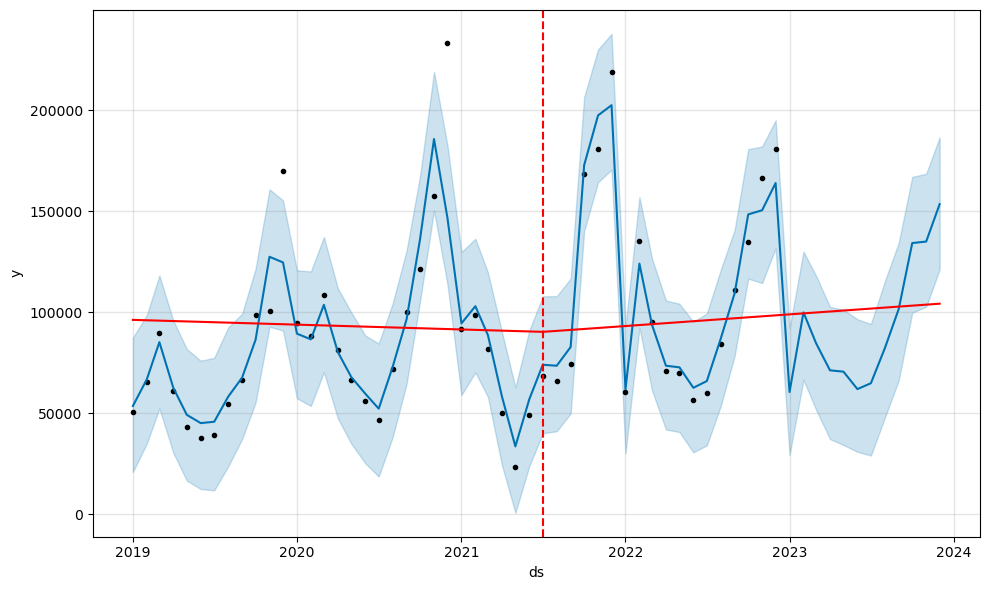

In [18]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

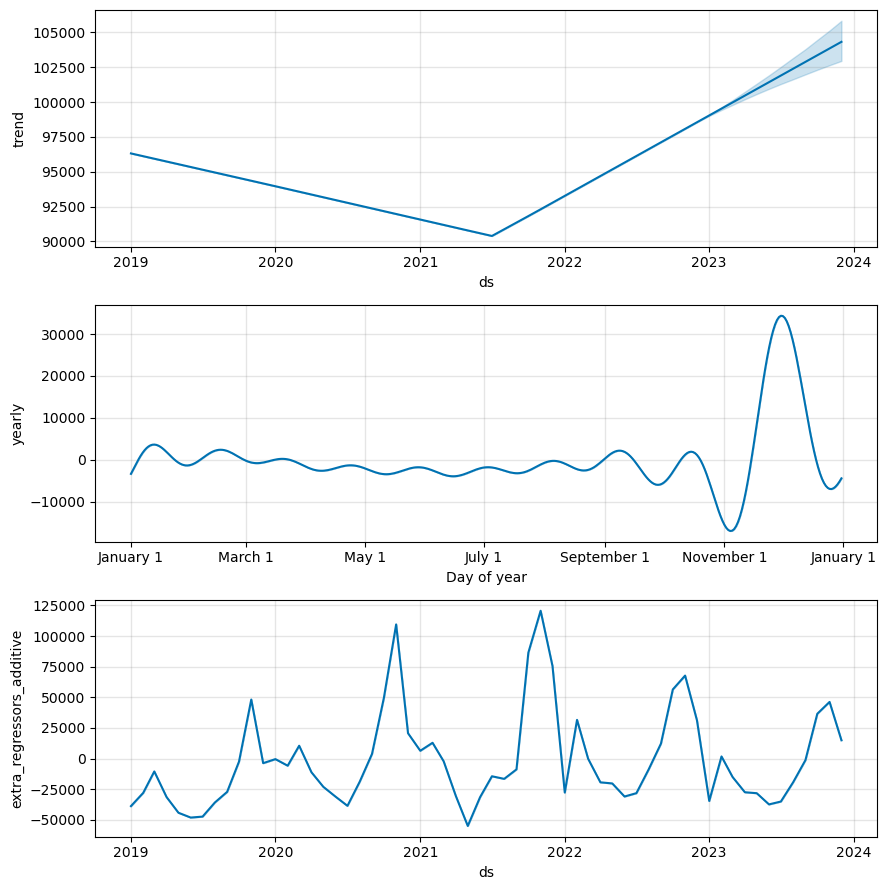

In [19]:
fig2 = model.plot_components(forecast)

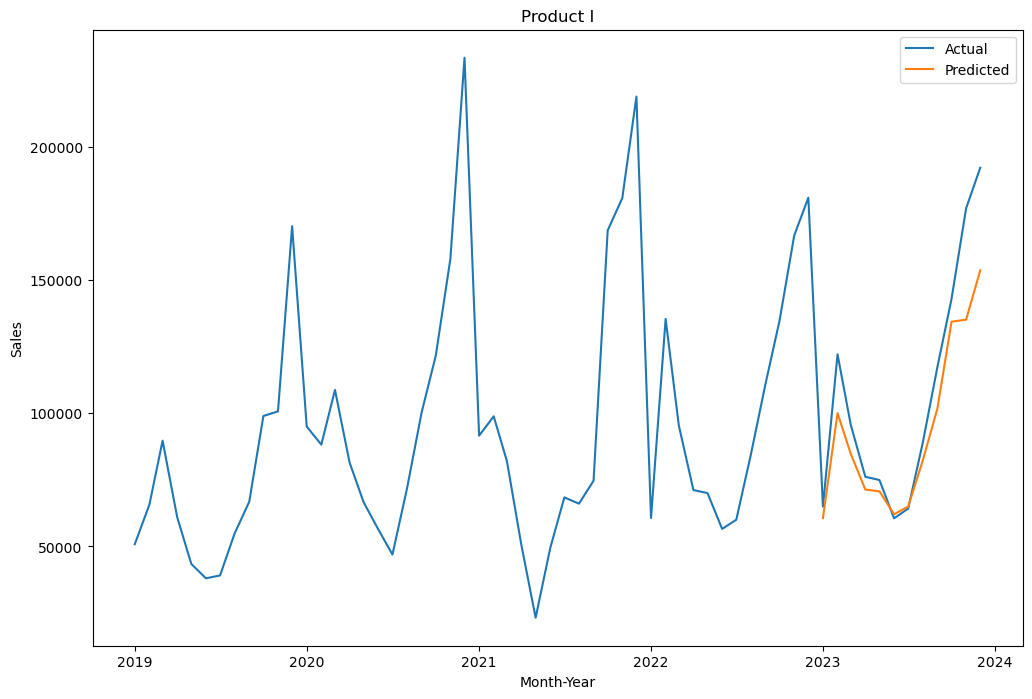

In [20]:
# Reset index of sales_b DataFrame
sales_i_reset_index = sales_i.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_i_reset_index['ds'], sales_i_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product I')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [21]:
#model evaluation

In [22]:
pred=forecasted_df['yhat']
test_df=test['y']

In [23]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 13308.831
MAPE - FB PROPHET: 0.102
MSE - FB PROPHET: 354927756.204
RMSE - FB PROPHET: 18839.526


In [24]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [25]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,4.984541e+06,2232.608510,2232.608510,0.036805,0.036805,0.037495,1.0
1,62 days,3.683324e+08,19191.988100,19191.988100,0.141764,0.141764,0.152579,1.0
2,90 days,6.901641e+07,8307.611796,8307.611796,0.087086,0.087086,0.091051,1.0
3,121 days,1.447446e+07,3804.531453,3804.531453,0.053470,0.053470,0.054938,1.0
4,151 days,1.698046e+07,4120.735297,4120.735297,0.058868,0.058868,0.060653,1.0
5,182 days,7.812903e+05,883.906268,883.906268,0.015628,0.015628,0.015751,1.0
6,212 days,3.358642e+06,1832.659740,1832.659740,0.030544,0.030544,0.031018,1.0
7,243 days,5.143918e+07,7172.111383,7172.111383,0.084910,0.084910,0.088675,1.0
8,274 days,1.713515e+08,13090.130795,13090.130795,0.117976,0.117976,0.125371,1.0
9,304 days,1.037518e+07,3221.052452,3221.052452,0.023883,0.023883,0.023601,1.0


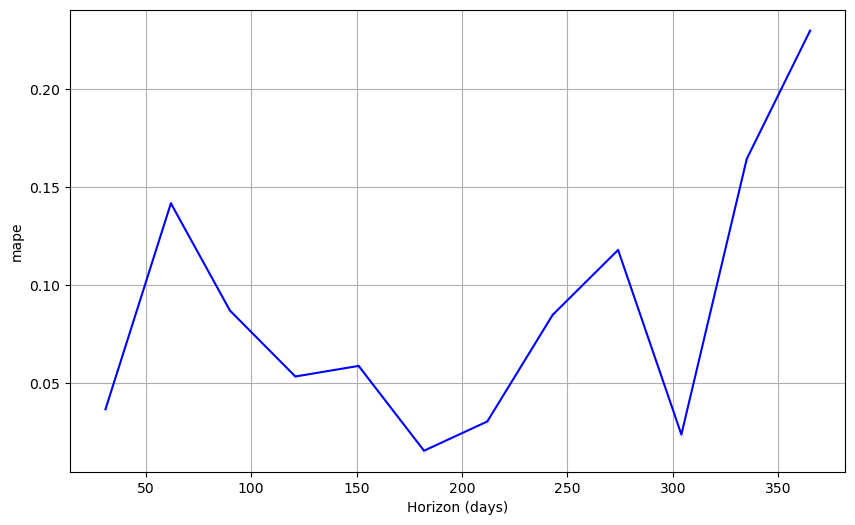

In [26]:
fig = plot_cross_validation_metric(df_cv, metric='mape')